# Semi-Supervised ML

In [85]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Pickle
import joblib

In [86]:
# Import custom class
%run -i '../src/helper/ss_transfxns.py'
%run -i '../src/helper/ss_ml.py'
%run -i '../src/helper/sup_ml.py'

# Load data

In [87]:
df = pd.read_csv('../data/kdd99-unsupervised-ad.csv', header = None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] # column names
df = (df.sample(frac =1)).reset_index(drop = True) # Shuffle the data
df.head() # display the data

Data size: (620098, 30)


,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,...,v_20,v_21,v_22,v_23,v_24,v_25,v_26,v_27,v_28,v_29
0,0.0,234.0,2005.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,254.0,1.0,0.0,0.02,0.17,0.0,0.0,0.7,0.94,n
1,0.0,321.0,1327.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.01,0.04,0.0,0.0,0.0,0.00,n
2,0.0,299.0,294.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.08,0.04,0.0,0.0,0.0,0.00,n
3,0.0,322.0,373.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,n
4,0.0,342.0,546.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,255.0,1.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,n


# Categorical variables encoded as integers

In [88]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

# Create feature matrix and class label

In [89]:
X, y = df.drop('v_29', axis = 1), df.v_29

# Create unlabeled dataset
In this section, we remove some labels and relabel them as unknown, which is indicated by -1

In [90]:
# Map to binary
y_ = y.map({'n':0, 'o':1})

In [91]:
n_total_samples = len(y_)
n_labeled_points = 100000

#####################################################
indices = np.arange(n_total_samples)
unlabeled_set = indices[n_labeled_points:]

#####################################################
y_train = np.copy(y_)
y_train[unlabeled_set] = -1 # set unlabeled dataset to -1
y_true = y_[unlabeled_set] # True labels of the unlabeled dataset

In [92]:
print("Original class distribution")
label_pct = y_.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_)
label_ct =  y_.map({0:'normal',1: 'attack'}).value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

Original class distribution


,labels,count,percentage
0,normal,619046,99.830349
1,attack,1052,0.169651


In [93]:
print("Class distribution for semi-supervised learning")
label_pct = pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts()*100/len(y_train)
label_ct =  pd.Series(y_train).map({0:'normal',1: 'attack', -1: 'unknown'}).value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

Class distribution for semi-supervised learning


,labels,count,percentage
0,unknown,520098,83.873517
1,normal,99798,16.093908
2,attack,202,0.032575


In [94]:
print(" Class distribution for true labels of the unlabeled dataset")
label_pct = y_true.map({0:'normal',1: 'attack'}).value_counts()*100/len(y_true)
label_ct =  y_true.value_counts()
pd.DataFrame({'labels': label_pct.index, 'count': label_ct.values, 'percentage': label_pct.values})

 Class distribution for true labels of the unlabeled dataset


,labels,count,percentage
0,normal,519248,99.836569
1,attack,850,0.163431


# Transformation pipeline

In [95]:
# Instantiate the class
transfxn = TransformationPipeline()

In [96]:
# Transform and scale data
X_train_scaled, feat_nm = transfxn.preprocessing(X)

In [97]:
print('Training set size after pre-processing:', X_train_scaled.shape, y_train.shape)

Training set size after pre-processing: (620098, 33) (620098,)


# Self-Training Semi-Supervised Learning

In [98]:
# Instantiate the class
model = SemiSupervised()

## A-1. Logistic Regression

In [107]:
lr_base_classifier = LogisticRegression()
lr_y_pred, y_proba = model.self_training_clf(lr_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)

print('-' * 40)
print("Predicted labels for {} unlabeled data points: ".format(len(y_true)))
pd.Series(lr_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 520093 new labels.
End of iteration 2, added 3 new labels.
----------------------------------------
Predicted labels for 520098 unlabeled data points: 


0    519262
1       836
dtype: int64

## A-1-1. Performance metrics

We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [100]:
model.eval_metrics(y_true.values, lr_y_pred[unlabeled_set])

---------------------------------------------------------------------------
Test accuracy:  0.999946
AUROC: 0.987640
AUPRC: 0.967168
Predicted classes: [0 1]
Confusion matrix:
 [[519241      7]
 [    21    829]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    519248
           1       0.99      0.98      0.98       850

    accuracy                           1.00    520098
   macro avg       1.00      0.99      0.99    520098
weighted avg       1.00      1.00      1.00    520098

---------------------------------------------------------------------------


## A-1-2. PCA plot

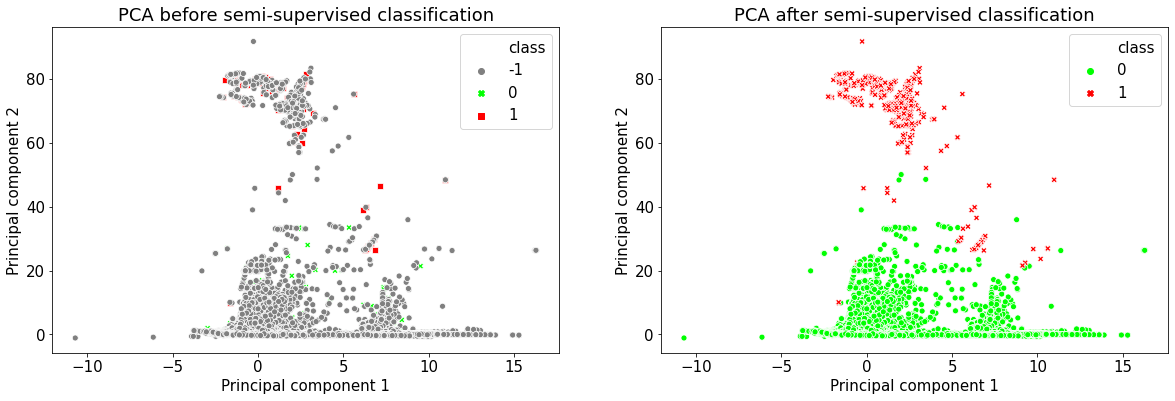

In [101]:
transfxn.plot_pca(X_train_scaled, y_train, lr_y_pred)

## A-2. Random Forest

In [108]:
rf_base_classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_y_pred, y_proba = model.self_training_clf(rf_base_classifier, X_train_scaled, y_train,
                                          threshold= 0.75, max_iter = None,verbose = True)

print('-' * 40)
print("Predicted labels for {} unlabeled data points: ".format(len(y_true)))
pd.Series(rf_y_pred[unlabeled_set]).value_counts()

End of iteration 1, added 520057 new labels.
End of iteration 2, added 3 new labels.
End of iteration 3, added 1 new labels.
End of iteration 4, added 5 new labels.
End of iteration 5, added 5 new labels.
End of iteration 6, added 11 new labels.
----------------------------------------
Predicted labels for 520098 unlabeled data points: 


0    519278
1       820
dtype: int64

## A-2-1. Performance metrics
We use the ground truth of the unlabeled dataset to validate the performance of the model, but in reality the ground truth of the unlabeled data points will not be provided

In [106]:
model.eval_metrics(y_true.values, rf_y_pred[unlabeled_set])

---------------------------------------------------------------------------
Test accuracy:  0.999938
AUROC: 0.982351
AUPRC: 0.962416
Predicted classes: [0 1]
Confusion matrix:
 [[519246      2]
 [    30    820]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    519248
           1       1.00      0.96      0.98       850

    accuracy                           1.00    520098
   macro avg       1.00      0.98      0.99    520098
weighted avg       1.00      1.00      1.00    520098

---------------------------------------------------------------------------


## A-2-2. PCA plot

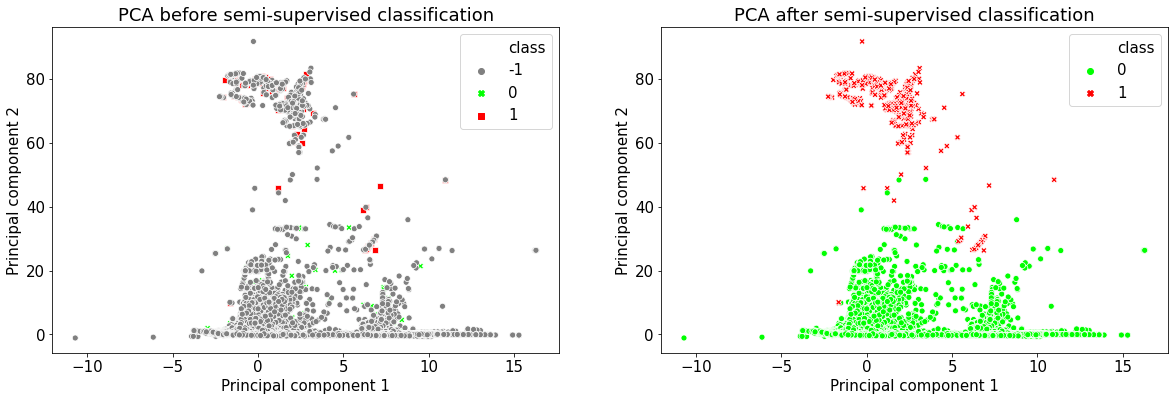

In [104]:
transfxn.plot_pca(X_train_scaled, y_train, rf_y_pred)